# Part 3.2: MNIST

According to the following website, to normalize the MNIST data, we should use the following Mean and Std values:
[link text](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457)

In [1]:
MNIST_mean=0.1307
MNIST_std=0.3081

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.cuda.is_available()

True

In [4]:
transform=torchvision.transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Normalize((MNIST_mean,),(MNIST_std,))
    ]
)

data_train=torchvision.datasets.MNIST("drive/MyDrive/Colab Notebooks/",train=True,download=True,transform=transform)
data_test=torchvision.datasets.MNIST("drive/MyDrive/Colab Notebooks/",train=False,download=True,transform=transform)

Creaet the model

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import math
import random

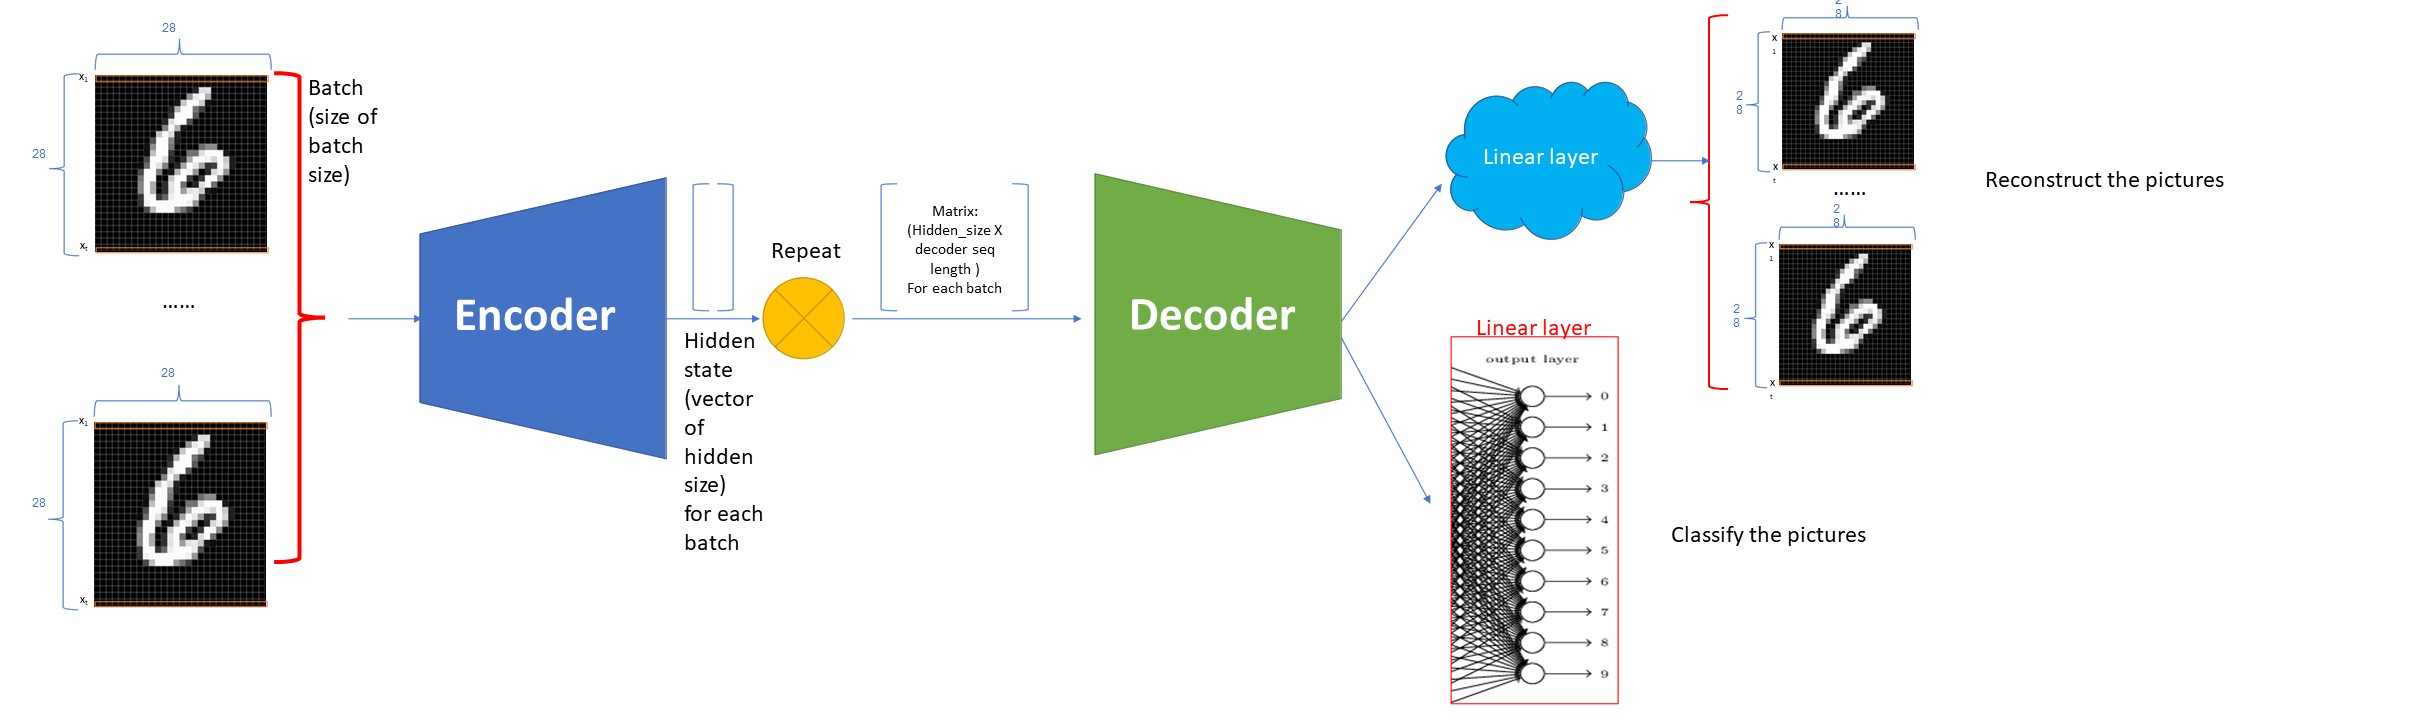

In [6]:
class MNIST(Dataset):
    def __init__(self, split, *, flatten=False):
        if flatten:
            self.imgs = [img.view(-1, 1) for img, _ in split]
        else:
            self.imgs = [img.squeeze(0) for img, _ in split]
        self.labels = [label for _, label in split]

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]

    def __len__(self):
        return len(self.imgs)

In [7]:
class MNIST_Outputs():
  def __init__(self,input_size,hidden_n):
    self.reconstructLinear=nn.Linear(hidden_n,input_size)
    self.classifyLinear=nn.Linear(hidden_n,10)
  
  def forward(self,lastHiddenState):
    self.outFromReconstruct=self.reconstructLinear(lastHiddenState)
    self.outFromClassifier=self.classifyLinear(lastHiddenState)
  
  

In [8]:
class encoder_decoder_MNIST(nn.Module):
    def __init__(self, input_size,hidden_n,seq_size):
        super().__init__()
        self.encoder=nn.LSTM(input_size,hidden_n,batch_first=True)
        self.decoder=nn.LSTM(hidden_n,hidden_n,batch_first=True)
        self.outputsCreator=MNIST_Outputs(input_size,hidden_n)
        self.reconstructLinear=nn.Linear(hidden_n,input_size)
        self.classifyLinear=nn.Linear(hidden_n,10)
        self.seq_size=seq_size
        self.input_size=input_size
        self.hidden_n=hidden_n

    def forward(self,x):
        
        _,(all_hidden,_)=self.encoder(x)
        
        last_hidden=all_hidden.view(-1,1,self.hidden_n)
        last_h_rep=last_hidden.repeat(1,self.seq_size,1)
        Y_out,_ = self.decoder(last_h_rep)
        lastHiddenState=Y_out
        outFromReconstruct=self.reconstructLinear(lastHiddenState)
        outFromClassifier=self.classifyLinear(lastHiddenState)
        #self.outputsCreator.forward(Y_out)

        return outFromReconstruct,outFromClassifier


In [26]:
class train_MNIST_Model():
    def __init__(self,
                 data,validationData,
                 sequenceLength,inputSize,
                 batchSize,hiddenSize,learningRate,gradientClipping,gradientClippingValue,numberOfIterations,
                 sgd_string="Adam",MSE_string="MSE"):
        self.bsz=batchSize
        self.hiddenSize=hiddenSize
        self.lr=learningRate
        self.bsz=batchSize
        self.clip=gradientClipping
        self.clipVal=gradientClippingValue
        self.iters=numberOfIterations

        self.ae=encoder_decoder_MNIST(inputSize,self.hiddenSize,sequenceLength)

        if(sgd_string=="sgd"):
            self.optim=optim.SGD(self.ae.parameters(),self.lr)
        else:
            self.optim=optim.Adam(self.ae.parameters(),self.lr)

        self.x_data=data
        self.validationData=validationData
        self.MES_string=MSE_string

    def train(self):
        trainingLosses=[]
        train_accs=[]
        validationLosses=[]
        
        GPU_or_CPU=torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.GPU_or_CPU=GPU_or_CPU
        if(GPU_or_CPU!="cpu"):
          print(f"working on GPU:{GPU_or_CPU}")
        theAE=self.ae.to(GPU_or_CPU)
        for i in range(self.iters):
            curr_loss=0
            train_correct=0
            train_total=0
            for x_dat,y_true in self.x_data:
                
                self.optim.zero_grad()
                currBatch=x_dat.to(GPU_or_CPU)
                currYtrue=y_true.to(GPU_or_CPU)
                
                outFromReconstruct,outFromClassifier=theAE.forward(currBatch)
                calc_andGetLoss=0
                if(self.MES_string=="MSE"):
                    calc_andGetLoss=nn.MSELoss().forward(outFromReconstruct,currBatch)+nn.CrossEntropyLoss().forward(outFromClassifier.view(len(currBatch),-1),currYtrue)
                calc_andGetLoss.backward() # calculate gradients
                self.optim.step()
                curr_loss+=calc_andGetLoss.item()
                with torch.no_grad():
                  train_correct+=(torch.argmax(outFromClassifier.view(len(currBatch),-1),dim=1)==currYtrue).sum().item()
                  train_total+=len(currBatch)
            avgLossForIter=curr_loss/len(self.x_data)
            trainingLosses.append(avgLossForIter)
            avgTrainAcc=train_correct/train_total
            train_accs.append(avgTrainAcc)
            print(f"Iteration={i+1}, TrainLoss={avgLossForIter}, Train acc={avgTrainAcc}")
        return trainingLosses,train_accs
    
    def inference(self,data):
      with torch.no_grad():
        dataOnDevice=data.to(self.GPU_or_CPU).unsqueeze(0)
        output=self.ae.forward(dataOnDevice)[0][0]
        theAxs=output.cpu().numpy()
      return theAxs
    
    def classify(self,data):
      dataOnDevice=data.to(self.GPU_or_CPU).unsqueeze(0)
      outputs=self.ae.forward(dataOnDevice)[1]
      return outputs.cpu()

In [17]:
#define the parameters
p_BatchSize=64
p_HiddenStateSize=100
p_LearningRate=0.001
p_GradienClipping=False
p_GradientClippingValue=0.1
p_NumberOfIterations=1
p_SequenceLenght=50

In [11]:
mnist_train = torchvision.datasets.MNIST("./data", train=True, download=True, transform=transform)
mnist_test = list(torchvision.datasets.MNIST("./data", train=False, download=True, transform=transform))

train = DataLoader(MNIST(mnist_train), batch_size=p_BatchSize, shuffle=True)
val = DataLoader(MNIST(mnist_test[:5000]), batch_size=p_BatchSize, shuffle=False)
test = DataLoader(MNIST(mnist_test[5000:]), batch_size=p_BatchSize, shuffle=False)

In [27]:
theTrainner=train_MNIST_Model(train,val,28,28,p_BatchSize,p_HiddenStateSize,p_LearningRate,p_GradienClipping,p_GradientClippingValue,p_NumberOfIterations)
theTrainner.train()

working on GPU:cuda
Iteration=1, TrainLoss=1.3761147927882067, Train acc=0.81365


([1.3761147927882067], [0.81365])

[5]


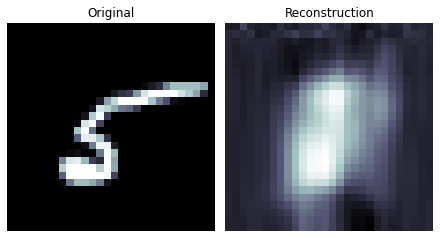

In [35]:
img = random.choice(next(iter(test))[0])

outputs=theTrainner.classify(img)
print(torch.argmax(outputs.view(1,-1),dim=1).detach().numpy())


fig, axs = plt.subplots(1, 2, constrained_layout=True)
axs[0].imshow(img.numpy(), cmap="bone")
axs[0].axis("off")
axs[0].set_title("Original")
axs[1].imshow(theTrainner.inference(img),cmap="bone")
axs[1].axis("off")
axs[1].set_title("Reconstruction")
plt.show()



[3]


https://discuss.pytorch.org/t/autoencoder-and-classification-inside-the-same-model/36248

In [ ]:
t=torch.rand(10,4)
t

tensor([[0.4382, 0.4368, 0.7741, 0.0589],
        [0.6600, 0.5606, 0.8348, 0.7745],
        [0.1553, 0.9855, 0.2464, 0.1930],
        [0.6130, 0.7446, 0.3051, 0.7864],
        [0.7261, 0.4827, 0.8300, 0.1967],
        [0.1941, 0.8864, 0.4930, 0.9426],
        [0.3429, 0.2261, 0.2751, 0.8395],
        [0.7633, 0.9955, 0.1829, 0.9867],
        [0.7819, 0.9638, 0.5270, 0.4458],
        [0.5261, 0.5851, 0.6702, 0.7610]])

In [ ]:
t.view(5,-1)

tensor([[0.4382, 0.4368, 0.7741, 0.0589, 0.6600, 0.5606, 0.8348, 0.7745],
        [0.1553, 0.9855, 0.2464, 0.1930, 0.6130, 0.7446, 0.3051, 0.7864],
        [0.7261, 0.4827, 0.8300, 0.1967, 0.1941, 0.8864, 0.4930, 0.9426],
        [0.3429, 0.2261, 0.2751, 0.8395, 0.7633, 0.9955, 0.1829, 0.9867],
        [0.7819, 0.9638, 0.5270, 0.4458, 0.5261, 0.5851, 0.6702, 0.7610]])